→ Formas detectadas: 355
→ Área promedio:   1327.76 píxeles²
→ Perímetro medio: 64.53 píxeles


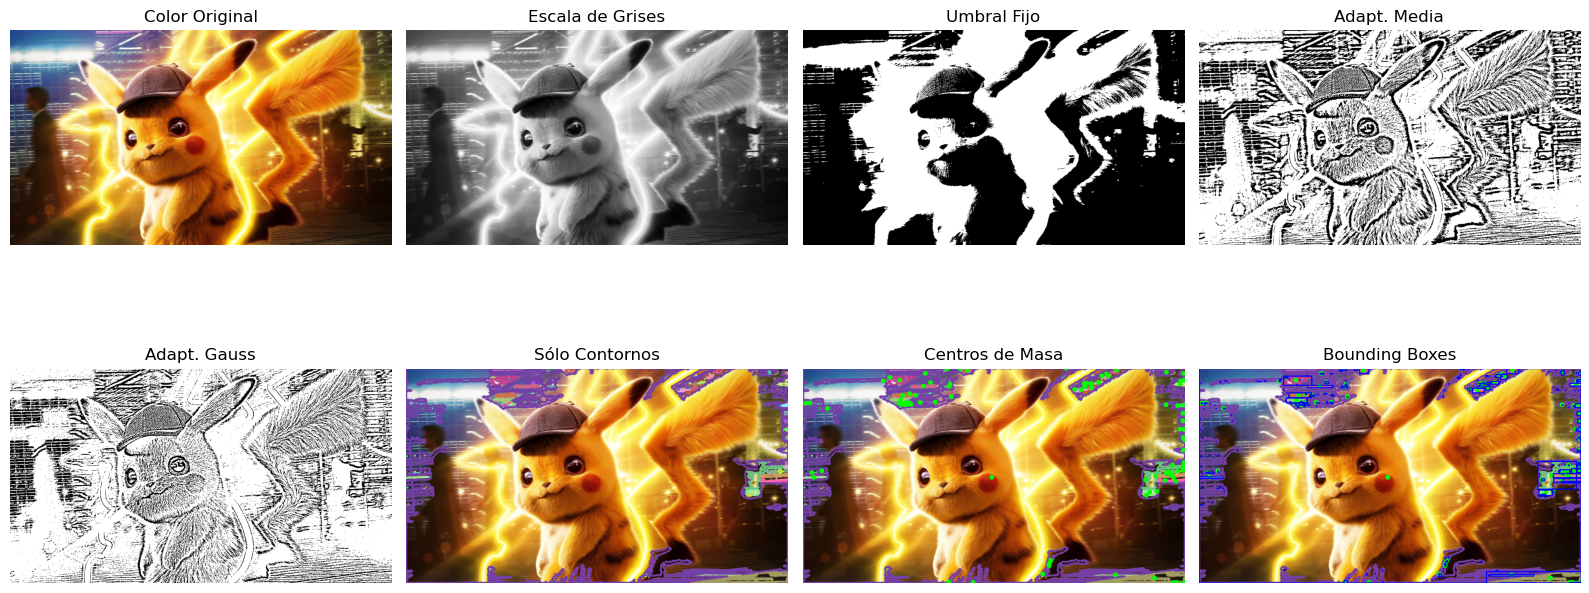

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import random

# ─── 1. CARGA Y PREPARACIÓN DE IMAGEN ─────────────────────────────────────────
ruta_imagen = 'sample_image.jpg'
img_color = cv2.imread(ruta_imagen)  # imagen en BGR
h, w = img_color.shape[:2]
# reducir a la mitad
img_color = cv2.resize(img_color, (w//2, h//2), interpolation=cv2.INTER_AREA)
img_gris = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# ─── 2. BINARIZACIÓN ───────────────────────────────────────────────────────────
# umbral fijo
_, umbral_fijo = cv2.threshold(img_gris, 128, 255, cv2.THRESH_BINARY)
# adaptativo media
umbral_adapt_m = cv2.adaptiveThreshold(
    img_gris, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    blockSize=13, C=4
)
# adaptativo gaussiano
umbral_adapt_g = cv2.adaptiveThreshold(
    img_gris, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    blockSize=13, C=4
)

# ─── 3. DETECCIÓN DE CONTORNOS ─────────────────────────────────────────────────
# usamos el umbral adaptativo por media
contornos, _ = cv2.findContours(umbral_adapt_m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# lienzo para dibujar contornos
lienzo_contornos = img_color.copy()
random.seed(1234)
for c in contornos:
    color = (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))
    cv2.drawContours(lienzo_contornos, [c], -1, color, 3)

# ─── 4. CENTROS DE MASA ────────────────────────────────────────────────────────
lienzo_centros = lienzo_contornos.copy()
for c in contornos:
    M = cv2.moments(c)
    if M['m00'] > 0:
        x_c = int(M['m10'] / M['m00'])
        y_c = int(M['m01'] / M['m00'])
        cv2.circle(lienzo_centros, (x_c, y_c), 6, (0, 255, 0), -1)

# ─── 5. BOUNDING BOXES ─────────────────────────────────────────────────────────
lienzo_bbox = lienzo_centros.copy()
for c in contornos:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(lienzo_bbox, (x, y), (x+w, y+h), (255, 0, 0), 2)

# ─── 6. CÁLCULO DE MÉTRICAS ────────────────────────────────────────────────────
areas = [cv2.contourArea(c) for c in contornos]
perimetros = [cv2.arcLength(c, True) for c in contornos]

print(f"→ Formas detectadas: {len(contornos)}")
print(f"→ Área promedio:   {np.mean(areas):.2f} píxeles²")
print(f"→ Perímetro medio: {np.mean(perimetros):.2f} píxeles")

# ─── 7. PREPARAR CARPETA DE SALIDA ─────────────────────────────────────────────
os.makedirs('resultados', exist_ok=True)

# ─── 8. GENERAR GIFs ANIMADOS ──────────────────────────────────────────────────
# GIF 1: Color original → Escala de grises
frames1 = [
    cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(img_gris, cv2.COLOR_GRAY2RGB)
]
imageio.mimsave('resultados/original_vs_gris.gif', frames1, duration=1.0)

# GIF 2: Secuencia de umbralización
frames2 = []
for m in (umbral_fijo, umbral_adapt_m, umbral_adapt_g):
    frames2.append(cv2.cvtColor(m, cv2.COLOR_GRAY2RGB))
imageio.mimsave('resultados/umbralizacion_secuencia.gif', frames2, duration=1.2)

# GIF 3: Proceso completo de detección
frames3 = [
    cv2.cvtColor(lienzo_contornos, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(lienzo_centros, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(lienzo_bbox, cv2.COLOR_BGR2RGB)
]
imageio.mimsave('resultados/deteccion_animada.gif', frames3, duration=1.5)

# ─── 9. VISUALIZAR TODO CON MATPLOTLIB ─────────────────────────────────────────
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.ravel()
titulos = [
    'Color Original', 'Escala de Grises', 'Umbral Fijo', 'Adapt. Media',
    'Adapt. Gauss', 'Sólo Contornos', 'Centros de Masa', 'Bounding Boxes'
]
imagenes = [
    img_color, img_gris, umbral_fijo, umbral_adapt_m,
    umbral_adapt_g, lienzo_contornos, lienzo_centros, lienzo_bbox
]

for ax, img, titulo in zip(axs, imagenes, titulos):
    ax.set_title(titulo)
    ax.axis('off')
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()
